# 1. Opening and cleaning

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


In [92]:

df = pd.read_pickle('data/clean/merged_dataframe.pkl')
cancer_df = pd.read_pickle('data/clean/ligands_related_to_cancer_proteins.pkl')
# interest_prot_df = pd.read_pickle('data/clean/interest_proteins.pkl')


### Keep only the ones matched with Drugbank to have the toxicity reports

In [93]:
df_matched = df[df['Matched_On'].isna() == False]
cancer_df_matched = cancer_df[cancer_df['Matched_On'].isna() == False]


In [94]:
print("Number of matched elements :",len(df_matched),"out of",len(df), "=",np.round(len(df_matched)/len(df) *100,2),"%")
print("Number of approved patents :",len(df_matched[df_matched["drugbank_drug_patent_approved"].isna() == False]),"out of",len(df_matched),"=",np.round(len(df_matched[df_matched["drugbank_drug_patent_approved"].isna() == False])/len(df_matched) *100,2),"%")

Number of matched elements : 151443 out of 2927609 = 5.17 %
Number of approved patents : 57080 out of 151443 = 37.69 %


# Grouping by drug
The columns for this are : 
- the number of entries for that drug
- the number rows that have an approved patent
- the unique toxicity reports
- the InChI keys
- the ligand names
- the number of proteins per drug
- the number of ligand per drug
- the list of unique toxicity reports per drug
- the number of different toxicity reports

In [ ]:
grouped_df = df_matched.groupby("drugbank_drug_name").agg({
    "drugbank_drug_name": "count",
    "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
    "drugbank_drug_toxicity": lambda x: x.unique(),
    "inchi_key" : lambda x: x.unique(),
    "ligand_name" : lambda x: x.unique()
}).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

grouped_df["num_prot_per_drug"] = grouped_df["inchi_key"].apply(lambda x: len(x))
grouped_df["num_lig_per_drug"] = grouped_df["ligand_name"].apply(lambda x: len(x))
grouped_df["unique_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: x[0] )
grouped_df["num_diff_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: len(x) )

grouped_df.head()

,count,drugbank_drug_patent_approved,drugbank_drug_toxicity,inchi_key,ligand_name,num_prot_per_drug,num_lig_per_drug,unique_toxicity,num_diff_toxicity
drugbank_drug_name,,,,,,,,,
Staurosporine,2369,0,[nan],"[HKSZLNNOFSGOKW-FYTWVXJKSA-N, HKSZLNNOFSGOKW-U...","[(2S,3R,4R,6R)-3-methoxy-2-methyl-4-(methylami...",2,4,NaN,1
Acetazolamide,2344,0,[nan],[BZKPWHYZMXOIDC-UHFFFAOYSA-N],"[AZA::AZA2::AZM acetazolamide::Acerazolamide, ...",1,1,NaN,1
Vorinostat,1736,1736,[nan],[WAEXFXRVDQXREF-UHFFFAOYSA-N],[CHEMBL98::N-hydroxy-N'-phenyloctanediamide::S...,1,1,NaN,1
Sunitinib,1692,1692,"[The maximally tolerated dose for rat, mouse, ...",[WINHZLLDWRZWRT-ATVHPVEESA-N],[CHEMBL535::N-[2-(diethylamino)ethyl]-5-[(Z)-(...,1,2,"The maximally tolerated dose for rat, mouse, a...",1
Sorafenib,1660,1660,[The oral lowest published toxic dose (Toxic D...,[MLDQJTXFUGDVEO-UHFFFAOYSA-N],[4-[4-({[4-chloro-3-(trifluoromethyl)phenyl]ca...,1,2,The oral lowest published toxic dose (Toxic Do...,1


In [96]:
grouped_df_cancer = cancer_df_matched.groupby("drugbank_drug_name").agg({
    "drugbank_drug_name": "count",
    "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
    "drugbank_drug_toxicity": lambda x: x.unique(),
    "inchi_key" : lambda x: x.unique(),
    "ligand_name" : lambda x: x.unique()
}).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

grouped_df_cancer["num_prot_per_drug"] = grouped_df_cancer["inchi_key"].apply(lambda x: len(x))
grouped_df_cancer["num_lig_per_drug"] = grouped_df_cancer["ligand_name"].apply(lambda x: len(x))

grouped_df_cancer["unique_toxicity"] = grouped_df_cancer["drugbank_drug_toxicity"].apply(lambda x: x[0] )
grouped_df_cancer["num_diff_toxicity"] = grouped_df_cancer["drugbank_drug_toxicity"].apply(lambda x: len(x) )

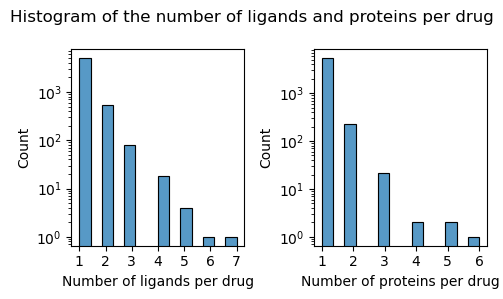

In [97]:
fig,axs = plt.subplots(1,2,figsize=(5,3))

# ligands
sns.histplot(grouped_df["num_lig_per_drug"],ax=axs[0])
axs[0].set_yscale("log")
axs[0].set_xlabel("Number of ligands per drug")
axs[0].set_xticks(np.arange(1, 8, 1))

# proteins
sns.histplot(grouped_df["num_prot_per_drug"], ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_xlabel("Number of proteins per drug")
axs[1].set_xticks(np.arange(1, 7, 1))

plt.suptitle("Histogram of the number of ligands and proteins per drug")
plt.tight_layout()

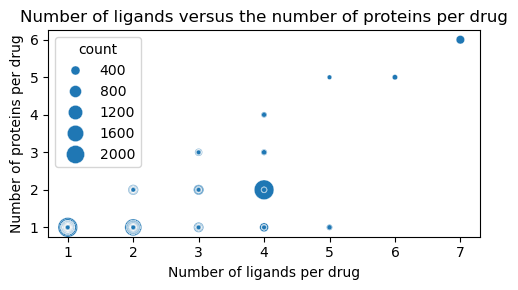

In [98]:
# plot of the number of ligand versus the number of proteins per drug
plt.figure(figsize=(5,3))
sns.scatterplot(data=grouped_df, x="num_lig_per_drug", y="num_prot_per_drug",size="count",sizes=(10, 200))
plt.xlabel("Number of ligands per drug")
plt.ylabel("Number of proteins per drug")
plt.title("Number of ligands versus the number of proteins per drug")
plt.tight_layout()

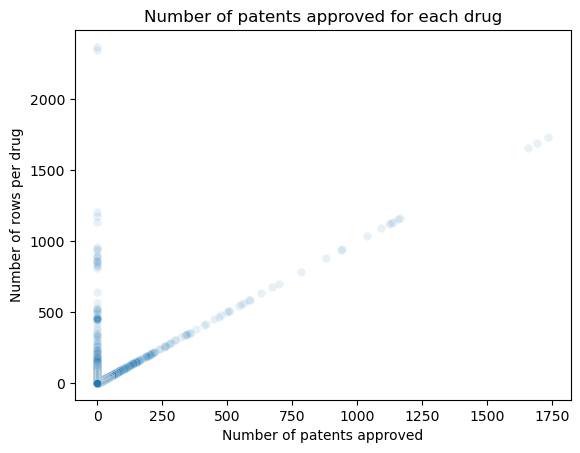

In [99]:
sns.scatterplot(grouped_df,x="drugbank_drug_patent_approved",y="count",alpha=0.1)
plt.xlabel("Number of patents approved")
plt.ylabel("Number of rows per drug")
plt.title("Number of patents approved for each drug")
plt.show()

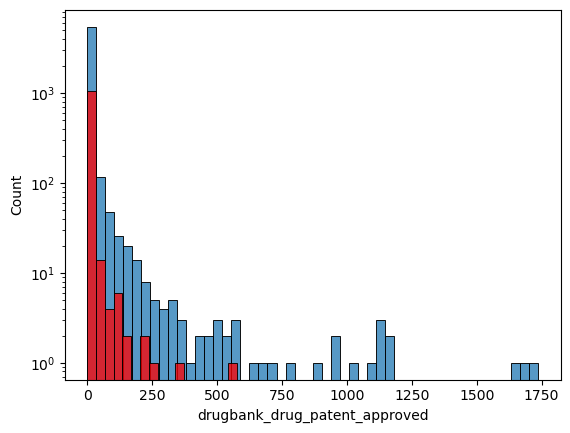

In [134]:
sns.histplot(grouped_df,x="drugbank_drug_patent_approved",bins=50)
sns.histplot(grouped_df_cancer,x="drugbank_drug_patent_approved",bins=17,color="red")

plt.yscale("log")

In [101]:
print("Total number of drugs :                  ",len(grouped_df))
print("Number of drugs with a toxicity report : ",sum(grouped_df["unique_toxicity"].isna() == False)) 
print("Number of unique toxicity reports :      ",len(grouped_df["unique_toxicity"].unique()))

Total number of drugs :                   5716
Number of drugs with a toxicity report :  1410
Number of unique toxicity reports :       1397


# Toxicity score

In [102]:
# Making a large string of all toxicity reports text
unique_toxicity_values = " ".join(grouped_df["unique_toxicity"].unique().astype(str))

In [103]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(unique_toxicity_values)

In [104]:
# Count the occurances of each word in that sting
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(5)

print(common_words)

[(',', 9840), ('of', 4577), ('.', 4334), ('and', 4304), ('in', 3832)]


In [105]:


# drop punctuation and stop words
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(1000000)

common_words

[('mg', 1779),
 ('kg', 1511),
 ('\r\n\r\n', 1211),
 ('overdose', 1003),
 ('>', 719),
 ('rats', 693),
 ('dose', 680),
 ('effects', 647),
 ('<', 611),
 ('patients', 560),
 ('oral', 559),
 ('doses', 547),
 ('LD', 538),
 ('include', 507),
 ('sub>50</sub', 460),
 ('studies', 456),
 ('adverse', 447),
 ('day', 415),
 ('human', 412),
 ('times', 400),
 ('mice', 367),
 ('toxicity', 361),
 ('reported', 351),
 ('LD50', 348),
 ('recommended', 339),
 ('FDA', 339),
 ('drug', 319),
 ('nausea', 309),
 ('symptoms', 304),
 ('rat', 298),
 ('supportive', 295),
 ('use', 286),
 ('risk', 282),
 ('vomiting', 273),
 ('Oral', 269),
 ('observed', 263),
 ('Label', 261),
 ('increased', 254),
 ('clinical', 247),
 ('treatment', 242),
 (' ', 236),
 ('hypotension', 232),
 ('administration', 224),
 ('associated', 222),
 ('Symptoms', 219),
 ('mouse', 215),
 ('severe', 213),
 ('including', 211),
 ('\r\n', 207),
 ('renal', 204),
 ('overdosage', 203),
 ('potential', 201),
 ('administered', 196),
 ('reactions', 192),
 ('preg

Hand picked words 

In [106]:
toxicity_related_frequent_words = ["overdose","adverse",'toxicity','LD50','nausea','vomiting','renal','hypotension','severe',
                                    'pain','fetal','pregnancy','reactions','fertility','blood','cardiac',"overdosage",'respiratory'
                                    ,'symptomatic','diarrhea','acute','headache','gastrointestinal','depression',"dizziness","coma",
                                    'liver','failure','mutagenic','acid','heart','abdominal','bradycardia','impairment','convulsions',
                                    'hypertension','anemia','anaphylactic','anaphylaxis','arrhythmias','arrhythmia','asthma','bronchospasm',
                                    'bronchial','cancer','carcinogenic','carcinogenicity','cardiotoxicity','cardiovascular','gastric',
                                    'seizures','confusion','hepatic',"carcinogenicity",'death','rash','mutation','arrhythmias',
                                    "overdose","patients", "effects","adverse","toxicity","symptoms","nausea","vomiting","treatment",
                                    "renal","hypotension","pregnancy","severe","pain","fetal","reactions","fertility","cardiac","diarrhea",
                                    "headache","gastrointestinal","depression","dizziness","coma","respiratory","symptomatic","acne",
                                    "liver","failure","drowsiness","seizures","muscle","maternal","gastric","hypertension","death",
                                    "rash","bladder","edema","children","weakness","insomnia","syndrome","anemia","tumors","acidosis",
                                    "impaired","infant","pediatric","hallucinations","nervous","irritation","fever","constipation",
                                    "adenomas","birth","gestation","developmental","prolonged","mutagenicity","lethal","fatigue",
                                    "sedation","thrombocytopenia","bradycardia","tachycardia","convulsions","arrhythmias","CNS","somnolence",
                                    "hemodialysis","breast","acne","hepatotoxicity","pulmonary","malformations","thrombocytopenia",
                                    "lactation","ventricular","sweating","atropine","kidney","hepatotoxicity","restlessness",
                                    "seizure","emesis","adrenal","carcinomas","neutropenia","allergy","toxicity","arrhythmias",
                                    "death","hypertension",]

high_severity = ["cancer","coma","severe","overdose","death","lethal","serious","life-threatening","life threatening","strokes","fatal","mortality"]

In [107]:
# very high severity side effects of cancer related drugs


In [108]:

toxicity_related_frequent_words = np.unique(toxicity_related_frequent_words)

low_severity = [word for word in toxicity_related_frequent_words if word not in high_severity]


In [109]:
import re
from bs4 import BeautifulSoup  # Use BeautifulSoup for HTML tag removal

# Function to parse text anad find lowest LD50 value if there is any
def parse_lowest_ld50(report):
    clean_report = BeautifulSoup(report, "html.parser").get_text()
    matches = re.findall(r"LD50[^\d]*(\d+)\s*", clean_report, re.IGNORECASE)
    if matches:
        # Convert matches to int and find the minimum
        ld50_values = list(map(int, matches))
        return min(ld50_values)
    return np.nan  # No LD50 value found


# Assign toxicity score based on lowest LD50 value
def assign_severity_score(ld50):
    if ld50 is None:
        return None  # No value, no score
    elif ld50 <= 50:
        return 20  # Extremely toxic
    elif ld50 <= 300:
        return 10  # Highly toxic
    elif ld50 <= 1000:
        return 5  # Moderately toxic
    elif ld50 <= 5000:
        return 2  # Slightly toxic
    else:
        return 0  # Practically non-toxic
    
# same as assign_severity_score but continuous
def assign_severity_score_continuous(ld50):
    if ld50 is None:
        return None  # No value, no score
    else :
        return max(20 - ld50/5000,0)

## Toxicity scoring 
The toxicity score is made from adding the score from a possible LD50 value, and weighted number of severity/toxicity/... related words. This score is then normalized by the word length of the toxicity report.

In [110]:
# all
grouped_df["toxicity_score"] =  grouped_df["unique_toxicity"].apply(lambda x: (sum(3 for word in high_severity if word in str(x)) + sum(1 for word in low_severity if word in str(x)) + int(assign_severity_score(parse_lowest_ld50(str(x))))) )
grouped_df["toxicity_score"] =  grouped_df["toxicity_score"]/grouped_df["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)

# cancer related
grouped_df_cancer["toxicity_score"] =  grouped_df_cancer["unique_toxicity"].apply(lambda x: (sum(3 for word in high_severity if word in str(x)) + sum(1 for word in low_severity if word in str(x)) + int(assign_severity_score(parse_lowest_ld50(str(x))))) )
grouped_df_cancer["toxicity_score"] =  grouped_df_cancer["toxicity_score"]/grouped_df_cancer["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)

/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_8376/390788417.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()
/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_8376/390788417.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()


In [111]:
grouped_df

,count,drugbank_drug_patent_approved,drugbank_drug_toxicity,inchi_key,ligand_name,num_prot_per_drug,num_lig_per_drug,unique_toxicity,num_diff_toxicity,toxicity_score
drugbank_drug_name,,,,,,,,,,
Staurosporine,2369,0,[nan],"[HKSZLNNOFSGOKW-FYTWVXJKSA-N, HKSZLNNOFSGOKW-U...","[(2S,3R,4R,6R)-3-methoxy-2-methyl-4-(methylami...",2,4,NaN,1,0.000000
Acetazolamide,2344,0,[nan],[BZKPWHYZMXOIDC-UHFFFAOYSA-N],"[AZA::AZA2::AZM acetazolamide::Acerazolamide, ...",1,1,NaN,1,0.000000
Vorinostat,1736,1736,[nan],[WAEXFXRVDQXREF-UHFFFAOYSA-N],[CHEMBL98::N-hydroxy-N'-phenyloctanediamide::S...,1,1,NaN,1,0.000000
Sunitinib,1692,1692,"[The maximally tolerated dose for rat, mouse, ...",[WINHZLLDWRZWRT-ATVHPVEESA-N],[CHEMBL535::N-[2-(diethylamino)ethyl]-5-[(Z)-(...,1,2,"The maximally tolerated dose for rat, mouse, a...",1,0.000000
Sorafenib,1660,1660,[The oral lowest published toxic dose (Toxic D...,[MLDQJTXFUGDVEO-UHFFFAOYSA-N],[4-[4-({[4-chloro-3-(trifluoromethyl)phenyl]ca...,1,2,The oral lowest published toxic dose (Toxic Do...,1,0.136364
...,...,...,...,...,...,...,...,...,...,...
Iniparib,1,0,[nan],[MDOJTZQKHMAPBK-UHFFFAOYSA-N],[BSI-201::INIPARIB::Iniparib],1,1,NaN,1,0.000000
Inhibitor of P38 Kinase,1,0,[nan],[UUEYCHLWAOBOHG-UHFFFAOYSA-N],[3-(2-(4-Pyridyl)ethyl)indole::3-[2-(pyridin-4...,1,1,NaN,1,0.000000
Inhibitor Idd 384,1,0,[nan],[CJKKMQCZOLCXAM-UHFFFAOYSA-N],"[2-(2,6-dimethyl-4-(2-o-tolylacetamido)phenyls...",1,1,NaN,1,0.000000


Data frame of entries with non-empty toxicity report

In [112]:
grouped_df_tox = grouped_df.loc[grouped_df["unique_toxicity"].isna() == False]
grouped_df_cancer_tox = grouped_df_cancer.loc[grouped_df_cancer["unique_toxicity"].isna() == False]

##### Make a df for the proteins of interest


In [ ]:
# prot_of_interest = grouped_df["a", "b", "c"]

Text(0.5, 1.0, 'Histogram of the weighted normalized toxicity score')

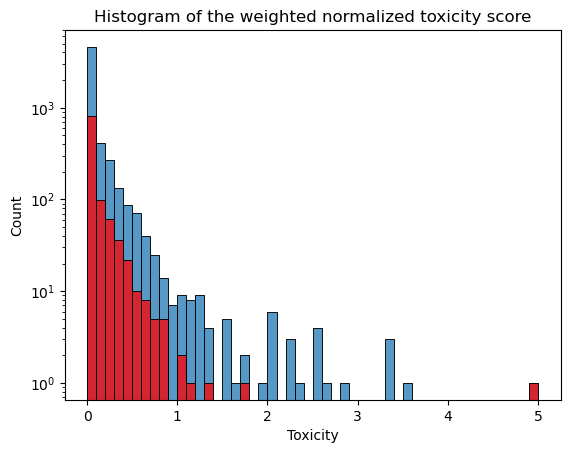

In [113]:
sns.histplot(grouped_df["toxicity_score"], bins=50)
sns.histplot(grouped_df_cancer["toxicity_score"], bins=50,color="red")

plt.yscale("log")
plt.xlabel("Toxicity")
plt.title("Histogram of the weighted normalized toxicity score")

Text(0.5, 1.0, 'Histogram of toxicity score')

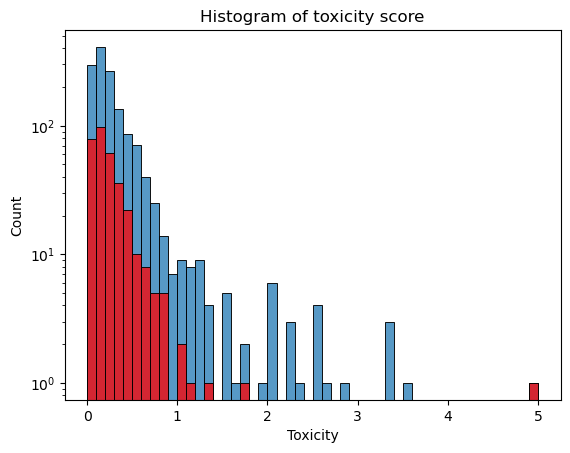

In [114]:
sns.histplot(grouped_df_tox["toxicity_score"], bins=50)
sns.histplot(grouped_df_cancer_tox["toxicity_score"], bins=50,color="red")

plt.yscale("log")
plt.xlabel("Toxicity")
plt.title("Histogram of toxicity score")

In [115]:
grouped_df_cancer_tox["toxicity_score"].mean(),grouped_df_tox["toxicity_score"].mean()

(0.2578432409354073, 0.30570585733237926)

Text(0.5, 1.0, 'Number of BindinDB entries per drug vs toxicity score')

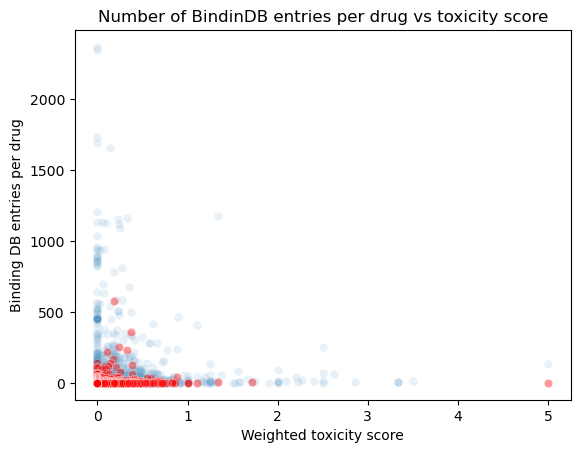

In [116]:
sns.scatterplot(grouped_df,x="toxicity_score",y = "count",alpha = 0.1)
sns.scatterplot(grouped_df_cancer,x="toxicity_score",y = "count",alpha = 0.4,color="red")
plt.xlabel("Weighted toxicity score")
plt.ylabel("Binding DB entries per drug")
# plt.yscale("log")
plt.title("Number of BindinDB entries per drug vs toxicity score")

Text(0.5, 1.0, 'Number of BindinDB entries per drug vs toxicity score')

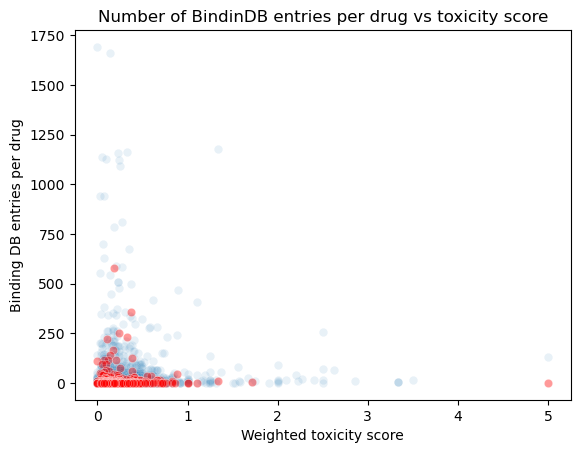

In [117]:
sns.scatterplot(grouped_df_tox,x="toxicity_score",y = "count",alpha = 0.1)
sns.scatterplot(grouped_df_cancer_tox,x="toxicity_score",y = "count",alpha = 0.4,color="red")
plt.xlabel("Weighted toxicity score")
plt.ylabel("Binding DB entries per drug")
# plt.yscale("log")
plt.title("Number of BindinDB entries per drug vs toxicity score")

<Axes: xlabel='toxicity_score', ylabel='count'>

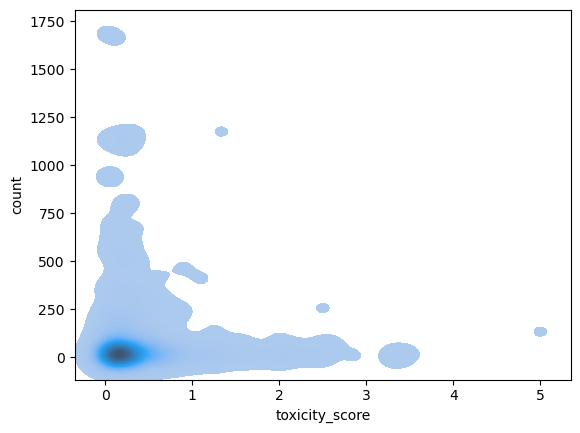

In [118]:
sns.kdeplot(data=grouped_df_tox, x="toxicity_score", y="count", fill=True, levels=100, thresh=0.01)

Text(0.5, 1.0, 'Number of proteins per drug vs toxicity score')

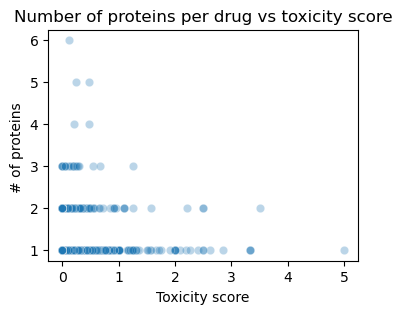

In [119]:
# plot of the number of unique toxicity values per protein
plt.figure(figsize=(4,3))
sns.scatterplot(grouped_df,x="toxicity_score",y = "num_prot_per_drug",alpha = 0.3)
plt.xlabel("Toxicity score")
plt.ylabel("# of proteins ")
# plt.yscale("log")
plt.title("Number of proteins per drug vs toxicity score")

<Axes: xlabel='toxicity_score', ylabel='num_prot_per_drug'>

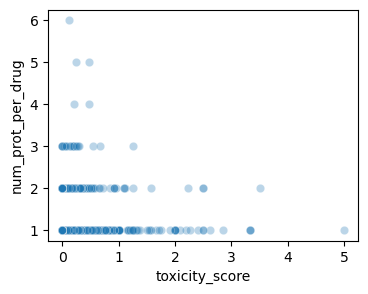

In [120]:
# plot of the number of unique toxicity values per protein
plt.figure(figsize=(4,3))
sns.scatterplot(grouped_df,x="toxicity_score",y = "num_prot_per_drug",alpha = 0.3)

Slope: -1.9516341983795389
Intercept: 47.82727974071961
R-squared: 3.751104949247202e-05
P-value: 0.8201782387381774


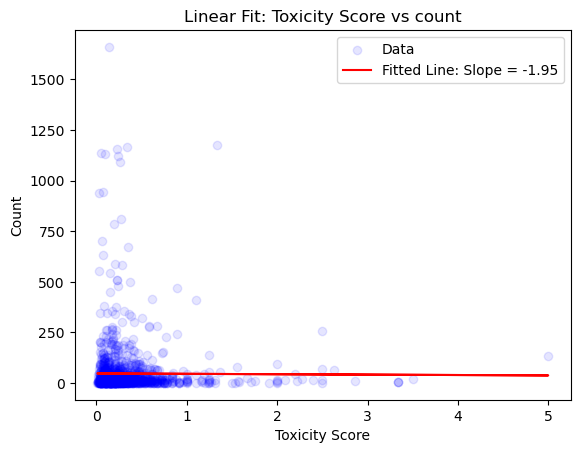

In [121]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

temp = grouped_df.copy()
temp = temp.loc[temp['toxicity_score'] > 0]
# Fit a linear regression with normal data
X = np.array(temp['toxicity_score'])
y = np.array(temp['count'])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

# Plot the data points
plt.scatter(X, y, color='blue', label='Data',alpha = 0.1)

# Plot the fitted line
plt.plot(X, slope*X + intercept, color='red', label=f"Fitted Line: Slope = {slope:.2f}")
plt.xlabel("Toxicity Score")
plt.ylabel("Count")
plt.title("Linear Fit: Toxicity Score vs count")
plt.legend()
plt.show()
